In [377]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [282]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

Функция для вывода информции о признаках.

In [283]:
def information(data):
    print(data.shape)
    info = pd.DataFrame(data.dtypes, columns=["type"])
    info["cnt_of_null"] = data.isnull().sum()
    info.sort_values(by="cnt_of_null", ascending=False, inplace=True)
    info["cnt_of_unique"] = data.nunique()
    info[["cnt_of_unique", "cnt_of_null"]] = info[
        ["cnt_of_unique", "cnt_of_null"]
    ].apply(pd.to_numeric)
    return info.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

Функция для оптимизации памяти.

In [284]:
def optimize_memory(data):
    optimized_data = data.copy()
    for col in optimized_data.columns:
        col_dtype = optimized_data[col].dtype
        if col_dtype == "int64":
            min_val = optimized_data[col].min()
            max_val = optimized_data[col].max()
            if min_val >= np.iinfo(np.int8).min and max_val <= np.iinfo(np.int8).max:
                optimized_data[col] = optimized_data[col].astype(np.int8)
            elif (
                min_val >= np.iinfo(np.int16).min and max_val <= np.iinfo(np.int16).max
            ):
                optimized_data[col] = optimized_data[col].astype(np.int16)
            elif (
                min_val >= np.iinfo(np.int32).min and max_val <= np.iinfo(np.int32).max
            ):
                optimized_data[col] = optimized_data[col].astype(np.int32)
        elif col_dtype == "int32":
            min_val = optimized_data[col].min()
            max_val = optimized_data[col].max()
            if min_val >= np.iinfo(np.int8).min and max_val <= np.iinfo(np.int8).max:
                optimized_data[col] = optimized_data[col].astype(np.int8)
            elif (
                min_val >= np.iinfo(np.int16).min and max_val <= np.iinfo(np.int16).max
            ):
                optimized_data[col] = optimized_data[col].astype(np.int16)
        elif col_dtype == "int16":
            min_val = optimized_data[col].min()
            max_val = optimized_data[col].max()
            if min_val >= np.iinfo(np.int8).min and max_val <= np.iinfo(np.int8).max:
                optimized_data[col] = optimized_data[col].astype(np.int8)
        elif col_dtype == "float64":
            min_val = optimized_data[col].min()
            max_val = optimized_data[col].max()
            if (
                min_val >= np.finfo(np.float32).min
                and max_val <= np.finfo(np.float32).max
            ):
                optimized_data[col] = optimized_data[col].astype(np.float32)
            elif (
                min_val >= np.finfo(np.float16).min
                and max_val <= np.finfo(np.float16).max
            ):
                optimized_data[col] = optimized_data[col].astype(np.float16)
        elif col_dtype == "float32":
            min_val = optimized_data[col].min()
            max_val = optimized_data[col].max()
            if (
                min_val >= np.finfo(np.float16).min
                and max_val <= np.finfo(np.float16).max
            ):
                optimized_data[col] = optimized_data[col].astype(np.float16)
        elif col_dtype == "object":
            num_unique_values = len(optimized_data[col].unique())
            num_total_values = len(optimized_data[col])
            if num_unique_values / num_total_values < 0.5:
                optimized_data[col] = optimized_data[col].astype("category")
    return optimized_data

Функция для извлечения информации из isrc.

In [285]:
def isrc_extract(data):
    data["country_code"] = data["isrc"].str[:2]
    data["publisher_code"] = data["isrc"].str[2:5]
    data["year"] = data["isrc"].str[5:7].astype(float)
    data["serial_number"] = data["isrc"].str[7:]

    data.drop(columns=["isrc"], inplace=True)
    return data

Извлечения информации из дат.

In [286]:
def date_extract(data):
    data["registration_init_time"] = pd.to_datetime(
        data["registration_init_time"], format="%Y%m%d"
    )
    data["expiration_date"] = pd.to_datetime(data["expiration_date"], format="%Y%m%d")

    data["registration_year"] = data["registration_init_time"].dt.year
    data["registration_month"] = data["registration_init_time"].dt.month
    data["registration_day"] = data["registration_init_time"].dt.day

    data["expiration_year"] = data["expiration_date"].dt.year
    data["expiration_month"] = data["expiration_date"].dt.month
    data["expiration_day"] = data["expiration_date"].dt.day

    data.drop(columns=["registration_init_time", "expiration_date"], inplace=True)
    return data

In [287]:
members = pd.read_csv("data/members.csv")
extra_info = pd.read_csv("data/song_extra_info.csv")
songs = pd.read_csv("data/songs.csv")
train = pd.read_csv("data/train.csv")

In [288]:
print(f"members shape: {members.shape}")
print(f"extra_info shape: {extra_info.shape}")
print(f"songs shape: {songs.shape}")
print(f"train shape: {train.shape}")

members shape: (34403, 7)
extra_info shape: (2295971, 3)
songs shape: (2296320, 7)
test shape: (2556790, 6)
train shape: (7377418, 6)


Сливаем данные в одну таблицу.

In [289]:
train = pd.merge(train, extra_info[extra_info.columns], on="song_id", how="left")
train = pd.merge(train, songs[songs.columns], on="song_id", how="left")
train = pd.merge(train, members[members.columns], on="msno", how="left")

In [290]:
del extra_info
del songs
del members

In [291]:
train = isrc_extract(train)
train = date_extract(train)

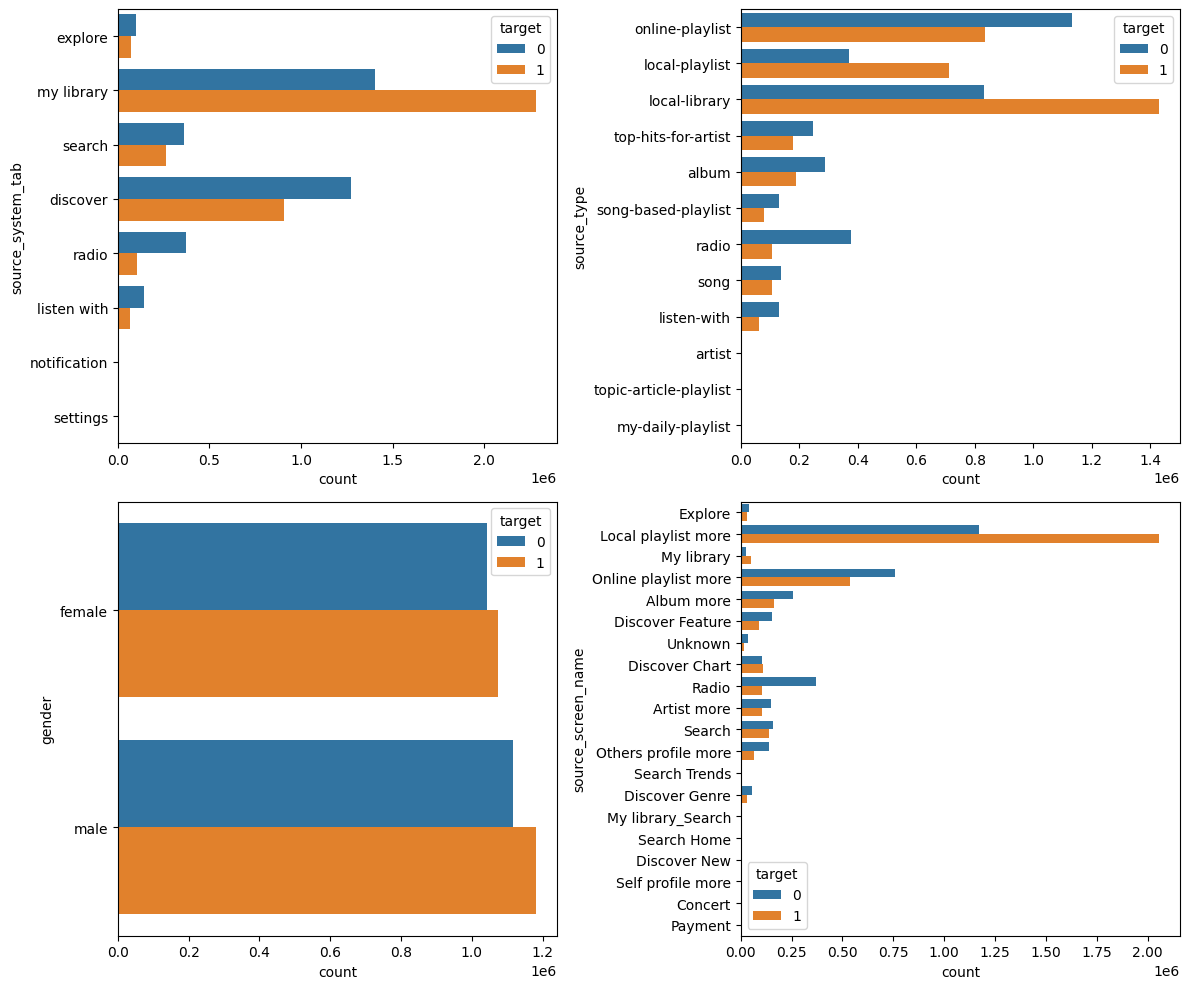

In [293]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.countplot(y="source_system_tab", data=train, hue="target", ax=axs[0, 0])
sns.countplot(y="source_type", data=train, hue="target", ax=axs[0, 1])
sns.countplot(y="gender", data=train, hue="target", ax=axs[1, 0])
sns.countplot(y="source_screen_name", data=train, hue="target", ax=axs[1, 1])

plt.tight_layout()

В целом, среди необработанных данных нет несбалансированных по целевой переменной классов, поэтому выравнивать и/или делать аугментацию не необходимо. Нужно лишь разобраться с пропусками и категориальными признаками с большим количеством классов.

In [294]:
train["genre_ids"] = train["genre_ids"].str.split("|")
train = train.explode("genre_ids", ignore_index=True)
train["genre_ids"] = train["genre_ids"].astype(float)

In [295]:
print(f"Используется памяти в train: {train.memory_usage().sum()/1024**2} МБ")
train = optimize_memory(train)
print(f"Используется памяти в train: {train.memory_usage().sum()/1024**2} МБ")

Используется памяти в train: 1422.9940223693848 МБ
Используется памяти в train: 489.33137130737305 МБ


Количество используемой памяти сократилось примерно в 3 раза. Отличный результат.

In [296]:
information(train)

(7771444, 27)


,type,cnt_of_null,cnt_of_unique
lyricist,category,3365903,33887
gender,category,3124408,2
composer,category,1792553,76064
year,float32,657227,100
publisher_code,category,657227,6455
country_code,category,657227,109
serial_number,category,657227,54979
source_screen_name,category,436075,20
genre_ids,float32,118455,166
source_system_tab,category,26103,8


In [297]:
train.sample(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,name,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,country_code,publisher_code,year,serial_number,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
185019,7ZQvUzGlJUE/cuEIG4nfsCIcPIY3A8179gjRkyMWIeI=,xPwE2YZ1fUQpyt1yMH44AQzpvlw9swnyOb1d7eE009E=,my library,Local playlist more,local-library,1,Melancholy,187663.0,444.0,B1A4,NaN,NaN,31.0,13,31,male,9,KR,A38,16.0,02466,2014,10,30,2017,12,6
3290007,64Xx6Qo7wWFlz4IlmCq+RqyAMmfjL6O4N1QymI4zL34=,YFEV6Zr6pHblLQ2cRiLQlH3dVwZPoyDHWY2urldqVFE=,discover,Discover Feature,online-playlist,0,Surfin',374955.0,1259.0,Kid Cudi,Scott Mescudi| Pharrell Williams,NaN,52.0,1,0,NaN,7,US,UM7,16.0,14716,2011,3,9,2017,9,12
7070304,V74EkRG7xGO+014UwkVQH8D8P4vovIcxM9tSDHSNs0U=,J1sgBEFbcXSK6eiN7CK1WNxsso0/sY6t0BMX+c+iPNw=,my library,Local playlist more,local-library,0,DJ Got Us Fallin' In Love,220450.0,139.0,Usher,NaN,NaN,52.0,17,0,NaN,7,US,LF2,10.0,00041,2011,5,18,2017,9,30
1509415,fqKeQuo02HWfqAkqCXBgKOlXq1afHn5uSX3cmboBn9k=,7CZp2Nb0f7tTSR/c3Vf41ILkMo3MlCe7hKc5gqAYZCU=,search,Radio,radio,0,Biology,144729.0,465.0,Girls Aloud,NaN,NaN,52.0,4,28,female,4,GB,UM7,5.0,00062,2016,12,2,2017,7,10
1021628,h7eXG9YWauqO7SupdEEBmlrrcjyUrlX1b9YxuFtT9aA=,wBTWuHbjdjxnG1lQcbqnK4FddV24rUhuyrYLd9c/hmk=,discover,Online playlist more,online-playlist,1,小幸運 (A little happiness),265508.0,465.0,田馥甄 (Hebe),JerryC,徐世珍/吳輝福,3.0,1,0,male,3,TW,D95,15.0,62101,2015,2,18,2017,10,1
882805,K5tHOIXrlTF5wGnz0o2XeUnTTrjhcmdz3xTQ+l5fOUk=,Vl5TmXU7tOERtow/PU6CaLBFTICTqKhe98JCfg3q8Us=,my library,Local playlist more,local-library,1,愛情怎麼喊停,263291.0,465.0,原來是美男 電視原聲帶,Kenn Wu,Yu Chen Mao,3.0,22,21,female,9,TW,A53,13.0,98910,2016,11,6,2017,10,11
1290471,kTziRfleMshHMBEyhEWz0Z4QbTk4uG8aWl9TDEyi880=,fCCmIa0Y5m+MCGbQga31MOLTIqi7ddgXvkjFPmfslGw=,discover,Discover Chart,online-playlist,1,默,283747.0,458.0,aMEI (張惠妹),Lei Qian,NaN,3.0,13,39,male,3,TW,UM7,16.0,00075,2015,6,10,2017,1,5
4201130,w8TJtIJbvHSrOT6X7ruo1r/4kJzGN8iCJhG6IyP6dLg=,MDxtMQJbjNfY/2pRstLXFRVgQlFg36a68xgNyZt2Fsk=,my library,Local playlist more,local-library,0,Me and Mrs. Jones,284995.0,139.0,Billy Paul,Kenneth Gamble| Leon Huff| Cary Gilbert,Kenneth Gamble| Leon Huff| Cary Gilbert,52.0,22,51,female,9,US,SM1,72.0,00413,2011,10,29,2017,10,30
5046374,PwnWgkloewAh6nr1MpRnSm6jbrltEb328ifDj7ccDZc=,zoabZodt2Kjkensobi4UpQhC3XWxN95bXnnRFtOiNhI=,discover,Online playlist more,song-based-playlist,1,Where Is The Love?,272509.0,139.0,The Black Eyed Peas,Justin Timberlake| Jaime Gomez| Allan Pineda| George Pajon Jr.| Michael Fratantuno| Printz Board| William Adams| J. Curtis,NaN,52.0,19,30,male,3,US,IR1,3.0,11862,2015,8,15,2017,9,10
3576840,mrjKYVskMUAksvPgRky/E2g/TiPdbpH1j5CCOzAC5RU=,1OKM59vvglCf6H+pyu+RDPQHQd0URrPduDt9faWUy/0=,listen with,Online playlist more,online-playlist,1,重傷,242102.0,465.0,林凡 (Freya Lim),Adrian Fu,魯維孝,3.0,1,0,NaN,3,TW,A45,10.0,99701,2014,5,5,2017,9,26


Самая банальная предобработка данных завершена. Дальше - более качественный анализ признаков.

В описании датасета сказано, что столбец с возрастом bd имеет выбросы. Проверю и заменю их на моду.

105.0

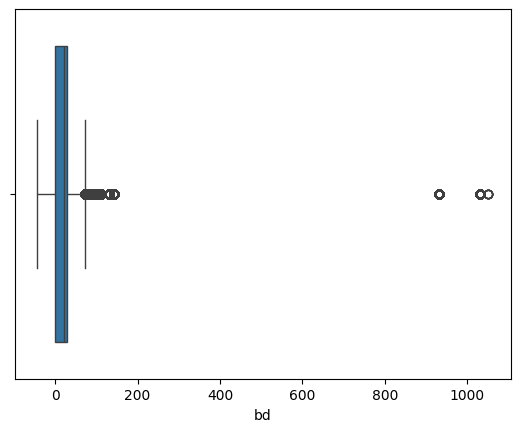

In [298]:
sns.boxplot(x=train["bd"])
train["bd"].quantile(0.95) + 1.5 * (
    train["bd"].quantile(0.95) - train["bd"].quantile(0.05)
)

In [299]:
procentile_bd = train["bd"].quantile(0.95) + 1.5 * (
    train["bd"].quantile(0.95) - train["bd"].quantile(0.05)
)

In [300]:
def change_bd_outliers(data):
    bd_mode = data["bd"].mode()[0]
    data.loc[data["bd"] < 1, "bd"] = bd_mode
    data.loc[
        data["bd"] > procentile_bd,
        "bd",
    ] = bd_mode
    return data

In [301]:
train = change_bd_outliers(train)

In [302]:
information(train)

(7771444, 27)


,type,cnt_of_null,cnt_of_unique
lyricist,category,3365903,33887
gender,category,3124408,2
composer,category,1792553,76064
year,float32,657227,100
publisher_code,category,657227,6455
country_code,category,657227,109
serial_number,category,657227,54979
source_screen_name,category,436075,20
genre_ids,float32,118455,166
source_system_tab,category,26103,8


Заполню пропуски.


In [304]:
def fill_nums(data):
    for col in data.columns:
        if data[col].dtype != "category":
            data[col] = data[col].fillna(data[col].mode()[0])
    return data

In [305]:
train = fill_nums(train)

In [306]:
information(train)

(7771444, 27)


,type,cnt_of_null,cnt_of_unique
lyricist,category,3365903,33887
gender,category,3124408,2
composer,category,1792553,76064
country_code,category,657227,109
serial_number,category,657227,54979
publisher_code,category,657227,6455
source_screen_name,category,436075,20
source_system_tab,category,26103,8
source_type,category,22476,12
name,category,1564,234144


lyricist, composer, artist_name имеют большое количество уникальных значений, притом являясь категориальными признаками. Чтобы не убирать их полностью, а оставить информацию хотя бы о количестве людей (заметил, что разделены они точно так, как и genre_ids, но не только через "|", но и через ";" и "/"), создадим новые столбцы. 

In [307]:
def add_cnt_cols(data):
    for col in ["lyricist", "composer", "artist_name"]:
        data[col] = data[col].astype(str)
        data[col] = data[col].fillna("unk")
        data[f"{col}_cnt"] = data[col].apply(
            lambda x: 1 + x.count("|") + x.count(";") + x.count("/")
        )
    return data

In [308]:
train = add_cnt_cols(train)

max_lyricist_cnt: 25
95_procentile_lyricist_cnt: 6.0
305663     Easy;Balanced;Motivated;Active;Determined;Passionate;Romantic;In love;Healthy;Uncompromising;Jazz;Fusion;Christmas Carols;Film Music;Bright;Elegant;Female vocal;Male vocal;Drums;Piano;Bass;Saxophone;Guitar (acoustic);Jazz band;Moderately slow.A great rom
305664     Easy;Balanced;Motivated;Active;Determined;Passionate;Romantic;In love;Healthy;Uncompromising;Jazz;Fusion;Christmas Carols;Film Music;Bright;Elegant;Female vocal;Male vocal;Drums;Piano;Bass;Saxophone;Guitar (acoustic);Jazz band;Moderately slow.A great rom
305665     Easy;Balanced;Motivated;Active;Determined;Passionate;Romantic;In love;Healthy;Uncompromising;Jazz;Fusion;Christmas Carols;Film Music;Bright;Elegant;Female vocal;Male vocal;Drums;Piano;Bass;Saxophone;Guitar (acoustic);Jazz band;Moderately slow.A great rom
305666     Easy;Balanced;Motivated;Active;Determined;Passionate;Romantic;In love;Healthy;Uncompromising;Jazz;Fusion;Christmas Carols;Film Music;Brigh

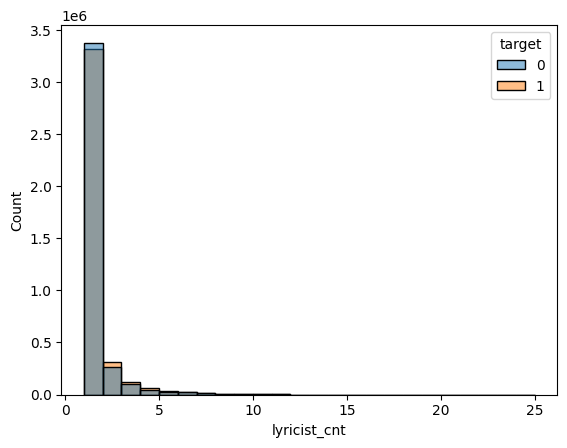

max_composer_cnt: 108
95_procentile_composer_cnt: 11.0
6191958    Korean Lyrics by Kim| Jong Hyun (12.5%) Harvey Mason| Jr. / Steven,,31\nw1zMqFE+5ynBzZil7EKEh2HvNHDLNvnlQ+al7cRBqjw=,281913,465,Madonna,,,52\nRcGEZpOfi+Y9D7JIIcUtyGP2MddfnhVzhfKKhEAJAtM=,210372,2022,Guns N' Roses,Caram Costanzo| W. Axl Rose| Brian Carroll,,52\n0KjXAae7rj9kfrIGhAoYBWJoQBqjtzTQMKMprbnStrs=,229506,,Monday Kiz,,,31\nvoMgKcLbhYr1GIsEuMvT+Rjkib1qvY4WPSmw/mc8j1c=,402703,940,Guy Sweens,,,-1\nPy+ROjXqGeJtSyQu1GWUEdvOkbEoKmBowX9lCq+E1Ow=,203593,1259,Pigeon John,,,52\n8jxho4ldBqaadnEiNjhgF8keOFBc4z6Gy6zTMKvw7Tg=,245856,465,Bertie Higgins,Bertie Higgins/Sonny Limbo,Bertie Higgins/Sonny Limbo,52\nImz3KL8KDLWIvNu/ytrFODhUvNCfziDLNdQP3OBIH/c=,347834,726,Hillsong Kids Junior,,,-1\nmRh2QjHNk3tcjKszLXpnCWUgREMRk6H4RDOdCn48T8w=,249568,465,Melanie C,Rick Nowels| Melanie Chisholm,,52\ntoozU/3UBRkzsNtZ8V4GXYHcb3zTNWVszGXKSP1x4qc=,212601,451,譚詠麟 (Alan Tam),Teddy Robin,,24\nSHpvIVpYFo+X19ccnFsuIQzNnidHdMHeg9sYzcP88LQ=,358400,21

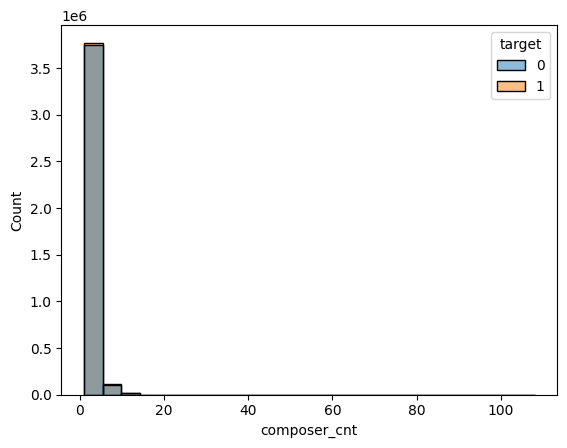

max_artist_name_cnt: 24
95_procentile_artist_name_cnt: 1.0
649701     Ronan Teague| Meik| Aima| R3tric| Shin Nishimura| Akos Veecs| Etai Tarazi| Pepote| Renderlive| Banjhaman| Bathsh3ba| Dubit| Daniel Whyte| J. OSCIUA| Fasol| Rocco Careri| Arturo Macchiavelli| Melo| Jorge| Manu P| Marcus Oliveira| DODX| 2LS 2 Dance| Morena
6024488    ZionTrain| MrPackage| Suv| Prospekt| DJ Bey| Dil Evans & Dave Mc Laud| LaoJam| SaviD| CAMPRESS| ALMAMEGRETTA| Reptilian| Zaimmo| NOJESUS| Anihlis| Monoblue| PABLO RASTER| FelixTheRedCat| Vata Grafix| Rikki| DSG| Twiztah| Nitrous| DJ Martello| Patrizia DJ
6024504    ZionTrain| MrPackage| Suv| Prospekt| DJ Bey| Dil Evans & Dave Mc Laud| LaoJam| SaviD| CAMPRESS| ALMAMEGRETTA| Reptilian| Zaimmo| NOJESUS| Anihlis| Monoblue| PABLO RASTER| FelixTheRedCat| Vata Grafix| Rikki| DSG| Twiztah| Nitrous| DJ Martello| Patrizia DJ
Name: artist_name, dtype: object


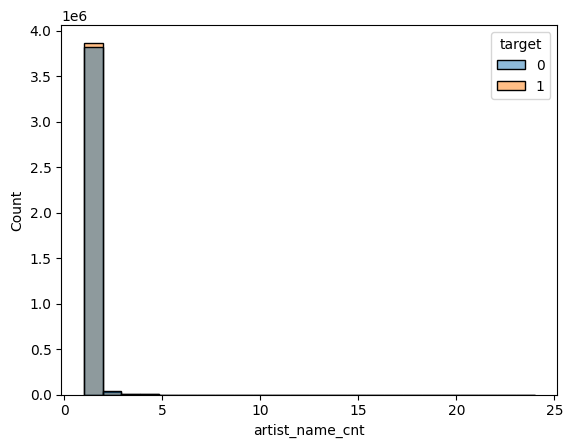

In [309]:
procentile_cnt = {}
for col in ["lyricist_cnt", "composer_cnt", "artist_name_cnt"]:
    sns.histplot(x=col, data=train, hue="target")
    print(f"max_{col}: {train[col].max()}")
    print(
        f"95_procentile_{col}: {train[col].quantile(0.95)+ 1.5 * (train[col].quantile(0.95) - train[col].quantile(0.05))}"
    )
    procentile_cnt[col] = train[col].quantile(0.95) + 1.5 * (
        train[col].quantile(0.95) - train[col].quantile(0.05)
    )
    print(train[train[col] == train[col].max()][col[:-4]])
    plt.show()

Как можно заметить, в колонках с именами могут находить ошибочные или сильно выбивающиеся по количеству данные. Избавлюсь от них полностью, так как их - меньшинство. 

Также значение 95 процентиля количества исполнителей равняется 1, поэтому от этого столбца можно избавить полностью, так как никакой полезной информации он не несет.

In [310]:
def remove_cnt_outliers(data):
    for col in ["lyricist_cnt", "composer_cnt"]:
        data = data[data[col] <= procentile_cnt[col]]
    return data

In [311]:
train = remove_cnt_outliers(train)

train.drop(
    columns=["artist_name_cnt", "artist_name", "lyricist", "composer"], inplace=True
)

In [312]:
information(train)

(7700667, 26)


,type,cnt_of_null,cnt_of_unique
gender,category,3095792,2
serial_number,category,656627,54959
country_code,category,656627,109
publisher_code,category,656627,6448
source_screen_name,category,432880,20
source_system_tab,category,25878,8
source_type,category,22276,12
name,category,1564,233626
msno,category,0,30746
lyricist_cnt,int64,0,6


In [313]:
train

,msno,song_id,source_system_tab,source_screen_name,source_type,target,name,song_length,genre_ids,language,city,bd,gender,registered_via,country_code,publisher_code,year,serial_number,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,lyricist_cnt,composer_cnt
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Good Grief,206471.0,359.0,52.0,1,0,NaN,7,GB,UM7,16.0,02854,2012,1,2,2017,10,5,1,2
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Lords of Cardboard,284584.0,1259.0,52.0,13,24,female,9,US,3C6,99.0,10183,2011,5,25,2017,9,11,1,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Hip Hop Is Dead(Album Version (Edited)),225396.0,1259.0,52.0,13,24,female,9,US,UM7,6.0,18761,2011,5,25,2017,9,11,1,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,Disco Africa,255512.0,1019.0,-1.0,13,24,female,9,GB,UQH,10.0,00063,2011,5,25,2017,9,11,1,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,Sleep Without You,187802.0,1011.0,52.0,1,0,NaN,7,QM,3E2,16.0,06003,2012,1,2,2017,10,5,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771439,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,Still D.R.E.,267958.0,1259.0,52.0,4,26,female,9,US,IR1,99.0,05031,2004,12,18,2017,9,30,1,4
7771440,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,Locked Away,227404.0,465.0,52.0,1,0,NaN,7,US,RC1,15.0,01369,2013,6,27,2017,10,6,5,5
7771441,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,FLY OUT,258298.0,465.0,3.0,1,0,NaN,7,TW,A45,15.0,12031,2013,6,27,2017,10,6,1,1
7771442,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,Wonderwall,524146.0,2122.0,52.0,5,0,NaN,9,US,NO1,7.0,50721,2015,2,13,2017,9,18,1,1


Была идея добавить признак, описывающий наличие фита в названии, но она оказалась неудачной ввиду того, что только в одном треке в названии указан этот самый фит.

In [314]:
train["name"].str.contains("ft|feat", case=False).any().sum()

1

In [315]:
train["gender"] = train["gender"].cat.add_categories(2)
train["gender"] = train["gender"].map({"male": 0, "female": 1})
train["gender"] = train["gender"].fillna(2)

In [317]:
information(train)

(7700667, 26)


,type,cnt_of_null,cnt_of_unique
serial_number,category,656627,54959
country_code,category,656627,109
publisher_code,category,656627,6448
source_screen_name,category,432880,20
source_system_tab,category,25878,8
source_type,category,22276,12
name,category,1564,233626
msno,category,0,30746
year,float32,0,100
lyricist_cnt,int64,0,6


Проверю столбец song_length.

In [318]:
train["song_length"] /= 60000

95_procentile_song_length: 9.01591670513153 мин
5_procentile_song_length: -0.7952834367752075 мин
max_song_length: 180.8617706298828 мин
min_song_length: 0.023216666653752327 мин
mode_song_length: 3.5458333492279053 мин


<Axes: xlabel='song_length', ylabel='Count'>

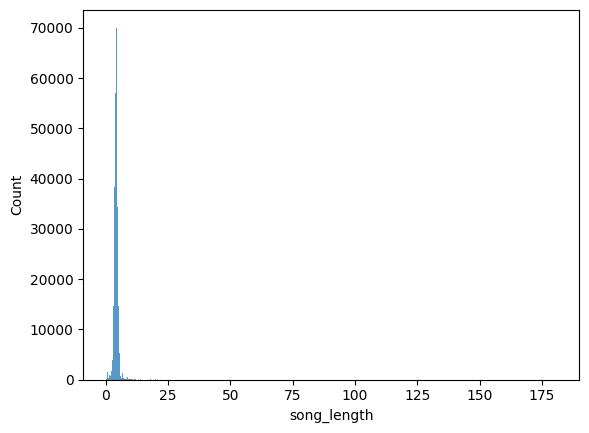

In [319]:
high_procentile_song_length = train["song_length"].quantile(0.95) + 1.5 * (
    train["song_length"].quantile(0.95) - train["song_length"].quantile(0.05)
)
low_procentile_song_length = train["song_length"].quantile(0.05) - 1.5 * (
    train["song_length"].quantile(0.95) - train["song_length"].quantile(0.05)
)
print(f'95_procentile_song_length: {high_procentile_song_length} мин')
print(f'5_procentile_song_length: {low_procentile_song_length} мин')
print(f'max_song_length: {train['song_length'].max()} мин')
print(f'min_song_length: {train['song_length'].min()} мин')
print(f'mode_song_length: {train['song_length'].mode()[0]} мин')
sns.histplot(data=train, x="song_length")

In [320]:
train[train["song_length"] >= high_procentile_song_length].sample(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,name,song_length,genre_ids,language,city,bd,gender,registered_via,country_code,publisher_code,year,serial_number,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,lyricist_cnt,composer_cnt
3642229,UwlS5UsLoZH5NRPf9IvTfGwjgfDvf1cXF0oPZeqxUYA=,Si8VTYFo1vXx1+5m6PIP5BqRHSnz2exjeS+mJGEFqwk=,search,Album more,album,1,Caravan,9.247733,921.0,52.0,1,0,2.0,7,US,3M5,14.0,28606,2013,12,19,2017,10,1,1,2
7694914,07iqQa1O/A8guTtEMUjuWbN5D4hT71iQku2m7/z/h6s=,jivzf4cIDsfp8XBp2Vl0KfSHkGt5aoGLUEEz0EBBSeI=,discover,Online playlist more,online-playlist,0,活殭屍與死殭屍,10.433884,474.0,-1.0,1,0,2.0,7,NaN,NaN,16.0,NaN,2016,2,8,2017,9,30,1,1
4540224,MfK3UbdvfDzgFCKTG9Q2CQYGwYxamtCVpb911+Puil4=,L0xMfBG6vrE0JKFbHLlEUMaBY5aG0dpaXumcEVli5rc=,discover,Album more,album,1,羅西尼：《鵲賊》序曲,9.482433,958.0,-1.0,13,45,0.0,7,NaN,NaN,16.0,NaN,2010,3,29,2018,3,13,1,1
2183323,aYYGQprcGIaKIdml7hjmwQiBSJ08UMwX6+tMXACo7u4=,5kW6525+i/VEACFKFdNCr+KwPHEhDmRJ1sH8O661ofs=,my library,Local playlist more,local-library,0,莫札特：Ａ大調豎笛協奏曲，K622 - 第一樂章：快板,12.794666,958.0,-1.0,22,35,0.0,9,GB,F07,62.0,10311,2010,12,14,2018,1,11,1,1
3657791,IRuvFq7Qu3V7Eq3QDR3GB/YkIbfASHk2tG0H1tMoGnU=,8KyL8rCCPpX0P7kRzYlHmaHSKH75a6vYeXPoWIjCIrs=,discover,Discover New,album,0,Mmxvi.2,11.800366,2086.0,52.0,21,30,0.0,9,DE,AR4,16.0,31727,2005,2,3,2017,10,3,1,1


Проверив названия некоторых выбивающихся по длине треков в интернете, выяснилось, что большая часть из них - либо классическая музыка, либо успокаивающая, либо дискотечная, и длина их вполне оправдана, поэтому считать их ошибочными выбросами я не могу. Возможно, их все же стоит убрать, чтобы уменьшить разброс, но сейчас кажется, что стоит все же оставить, а в дальнейшем сгладить стандартизацией.

Что делать с serial_number, country_code, publisher_code не совсем понятно. Это категориальные признаки с большим количестом классов и большим количеством пропуском. Можно попробовать заменить пропуски модой и применить label encoding, но на качестве это может не сказаться положительно. 

Еще, как вариант, можно попробовать кластеризировать (кажется, временные затраты не стоят того) или же полностью удалить. 

In [321]:
for col in ["country_code", "serial_number", "publisher_code"]:
    col_mode = train[col].mode()[0]
    train[col] = train[col].fillna(col_mode)

In [322]:
for col in ["country_code", "serial_number", "publisher_code"]:
    print(train[col].value_counts(), "\n")

country_code
TW    4328288
US    1255684
GB     409059
KR     378682
HK     374936
       ...   
BY          1
LT          1
YW          1
BK          1
ZZ          1
Name: count, Length: 109, dtype: int64 

serial_number
00001    736333
00002     49155
00003     45300
01001     37355
00004     29929
          ...  
14228         0
74854         0
35148         0
20082         0
18516         0
Name: count, Length: 54979, dtype: int64 

publisher_code
UM7    1269517
A53     573360
A45     395073
K23     303540
D95     245207
        ...   
D53          0
CC2          0
DP0          0
F10          0
B7Q          0
Name: count, Length: 6455, dtype: int64 



In [323]:
information(train)

(7700667, 26)


,type,cnt_of_null,cnt_of_unique
source_screen_name,category,432880,20
source_system_tab,category,25878,8
source_type,category,22276,12
name,category,1564,233626
msno,category,0,30746
publisher_code,category,0,6448
lyricist_cnt,int64,0,6
expiration_day,int8,0,31
expiration_month,int8,0,12
expiration_year,int16,0,18


source_screen_name, source_system_tab, source_type на первый взгляд кажутся хорошими категориальными признаками. Тоже заполню их пропуски модой. 

name вряд ли будет полезен, если не использовать векторные представления слов и семантическую кластеризацию, но это долго и дорого (вообще является уже другой задачей), поэтому пока что пропуски в этом признаке тоже просто заполню модой.

In [324]:
for col in ["source_screen_name", "source_system_tab", "source_type", "name"]:
    col_mode = train[col].mode()[0]
    train[col] = train[col].fillna(col_mode)

In [325]:
information(train)

(7700667, 26)


,type,cnt_of_null,cnt_of_unique
msno,category,0,30746
song_id,category,0,358669
lyricist_cnt,int64,0,6
expiration_day,int8,0,31
expiration_month,int8,0,12
expiration_year,int16,0,18
registration_day,int8,0,31
registration_month,int8,0,12
registration_year,int16,0,14
serial_number,category,0,54959


In [326]:
train[["year", "gender", "language", "genre_ids"]] = optimize_memory(
    train[["year", "gender", "language", "genre_ids"]].astype(int)
)

Все пропуски заполнены, теперь - финальная предобработка данных. Всего получилось 24 категориальных признака (включая количественные) и всего 1 song_length - численный.

In [327]:
cat_cols = train.drop(columns=["target", "song_length"], inplace=False).columns
target = train["target"]
train.drop(columns=["target"], inplace=True)

In [328]:
train[cat_cols] = train[cat_cols].astype("category")

Использую RobustScaler, так как в столбце song_length есть выбросы.

In [335]:
scaler = RobustScaler()
song_length_df = train[["song_length"]]
scaled_song_length = scaler.fit_transform(song_length_df)
train["song_length"] = scaled_song_length

По личному опыту, на подобных данных лучше всего себя показывает catboost, хорошо работающий именно с категориальными признаками. Применю его.

In [350]:
X_train, X_test, y_train, y_test = train_test_split(
    train, target, test_size=0.2, random_state=2704
)

In [378]:
catboost_clf = CatBoostClassifier(
    loss_function="Logloss",
    cat_features=cat_cols.to_list(),
    verbose=False,
    l2_leaf_reg=0.5,
    max_depth=5,
    iterations=200,
)

In [379]:
catboost_clf.fit(X_train, y_train, plot=True)
preds = catboost_clf.predict_proba(X_test)[:, 1]
print("ROC-AUC:", round(roc_auc_score(y_test, preds), 4))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC-AUC: 0.8566


Неплохой результат (AUC 0.8566), но это если строить бинарную систему, как сказано в описании kaggle-контеста. 
Если строить полную рекомендательную систему, нужно использовать другой подход.


In [382]:
rel_train = train[target != 0]
rel_train

,msno,song_id,source_system_tab,source_screen_name,source_type,name,song_length,genre_ids,language,city,bd,gender,registered_via,country_code,publisher_code,year,serial_number,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,lyricist_cnt,composer_cnt
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,Good Grief,-0.600673,359,52,1,0,2,7,GB,UM7,16,02854,2012,1,2,2017,10,5,1,2
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,Lords of Cardboard,0.755526,1259,52,13,24,1,9,US,3C6,99,10183,2011,5,25,2017,9,11,1,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,Hip Hop Is Dead(Album Version (Edited)),-0.272097,1259,52,13,24,1,9,US,UM7,6,18761,2011,5,25,2017,9,11,1,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,Disco Africa,0.250777,1019,-1,13,24,1,9,GB,UQH,10,00063,2011,5,25,2017,9,11,1,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,Sleep Without You,-0.924805,1011,52,1,0,2,7,QM,3E2,16,06003,2012,1,2,2017,10,5,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771438,iqvMM4aArQynHovYYKh0u5k2A+9uYuYX+wqZXV5LuxI=,0ftZO/ByXbLHmtLPt5NwATkT3OrbCuZ7CvrsnL3BvqQ=,my library,Local playlist more,local-library,Love Somebody,-0.195913,465,52,1,0,2,7,US,UM7,12,04774,2017,1,5,2017,10,5,1,4
7771439,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,Still D.R.E.,0.466865,1259,52,4,26,1,9,US,IR1,99,05031,2004,12,18,2017,9,30,1,4
7771441,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,FLY OUT,0.299147,465,3,1,0,2,7,TW,A45,15,12031,2013,6,27,2017,10,6,1,1
7771442,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,Wonderwall,4.914804,2122,52,5,0,2,9,US,NO1,7,50721,2015,2,13,2017,9,18,1,1


In [384]:
top_tracks = rel_train["song_id"].value_counts()
top_tracks

song_id
J4qKkLIoW7aYACuTupHLAPZYmRp08en1AEux+GSUzdw=    15806
v/3onppBGoSpGsWb8iaCIO8eX5+iacbH5a4ZUhT7N54=    13758
reXuGcEWDDCnL0K3Th//3DFG4S1ACSpJMzA+CFipo1g=    10885
T86YHdD4C9JSc274b1IlMkLuNdz4BQRB50fWWE7hx9g=    10556
FynUyq0+drmIARmK1JZ/qcjNZ7DKkqTY6/0O0lTzNUI=     9808
                                                ...  
SqBUJFbZ19IpOPa8SoNbAjaflFTWUCwxnAdFlWKqic8=        0
SqBe5wVSHV4oDADKLYAm5wkng/zSU9Aitq8QPjTXPwk=        0
SqC73mXIVmHz7NN8TTBKtx+mCKiZ0ce7F1XDzMOvnYM=        0
SqCX1+F5He1UNUhv7me5lLMzkLJOcHU0HnSPxtX55jk=        0
zzzkIR9d2ggpCr5ofvGZu0JFdjScoIxMgcV3dR4yKh0=        0
Name: count, Length: 359966, dtype: int64

In [387]:
tracks_per_user = (
    rel_train.groupby("msno", observed=False)["song_id"].apply(list).reset_index()
)

К сожалению, это занимает больше времени, поэтому я не успеваю его реализовать, но вот моя идея построения пайплайна:
1. Выберу те объекты, target которых равен 1;
2. Выберу топ самых популярных треков и буду рекомендовать их: это будет бейзлайном, то есть те подходы, которые будут приносить меньшее качества, буду считать негодными;
3. Сделаю sparse-матрицу;
4. Реализую item2item с помощью библиотеки, например, implicit. 
5. Использую ALS (тоже из implicit) для получения матриц пользователей и треков для дальнейшей нахождения близких.
6. Сравню результаты и займусь подбором параметров моделей.